> ### 3. The Impact of Transportation Methods on Air Quality in Big Cities

**Objective**: To analyze the relationship between transportation habits and air quality in urban areas to promote sustainable transportation options.

**Target Variable**: Air Quality (from metric_subcat_label)

**Relevant Independent Variables** (from metric_item_label):
- Public Transportation Use, 
- Drives Alone to Work, 
- Walking to Work, 
- Riding Bike to Work (from metric_item_label)


In [166]:
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim

import folium
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

### Exploring the dataset

In [196]:
# dataset: https://bigcitieshealthdata.org/

data = pd.read_csv('BigCitiesHealth.csv')
data.head()

C:\Users\pih\AppData\Local\Temp\ipykernel_20032\2530491087.py:3: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('BigCitiesHealth.csv')


,metric_item_label,metric_cat_label,metric_subcat_label,metric_item_label_subtitle,metric_cat_item_yaxis_label,metric_source_desc_label_fn,metric_source_desc_label_url_fn,geo_label_city,geo_label_state,geo_label_citystate,...,value_90_ci_low,value_90_ci_high,geo_strata_region,geo_strata_poverty,geo_strata_Population,geo_strata_PopDensity,geo_strata_Segregation,strata_race_label,strata_sex_label,strata_race_sex_label
0,COVID-19 Deaths,Infectious Diseases,Respiratory Infection,"Deaths from COVID-19 (per 100,000 population, ...","Per 100,000","National Vital Statistics System (NVSS), Cente...",https://www.cdc.gov/nchs/nvss/index.htm,San Antonio,TX,"San Antonio, TX",...,NaN,NaN,South,Less poor cities (<20% poor),Largest (>1.3 million),Lower pop. density (<10k per sq mi),Less Segregated (<50%),White,Male,White Male
1,COVID-19 Deaths,Infectious Diseases,Respiratory Infection,"Deaths from COVID-19 (per 100,000 population, ...","Per 100,000","National Vital Statistics System (NVSS), Cente...",https://www.cdc.gov/nchs/nvss/index.htm,Houston,TX,"Houston, TX",...,NaN,NaN,South,Poorest cities (20%+ poor),Largest (>1.3 million),Lower pop. density (<10k per sq mi),Highly Segregated (50%+),White,Male,White Male
2,COVID-19 Deaths,Infectious Diseases,Respiratory Infection,"Deaths from COVID-19 (per 100,000 population, ...","Per 100,000","National Vital Statistics System (NVSS), Cente...",https://www.cdc.gov/nchs/nvss/index.htm,Fort Worth,TX,"Fort Worth, TX",...,NaN,NaN,South,Less poor cities (<20% poor),Smaller (<1.3 million),Lower pop. density (<10k per sq mi),Less Segregated (<50%),White,Male,White Male
3,COVID-19 Deaths,Infectious Diseases,Respiratory Infection,"Deaths from COVID-19 (per 100,000 population, ...","Per 100,000","National Vital Statistics System (NVSS), Cente...",https://www.cdc.gov/nchs/nvss/index.htm,El Paso,TX,"El Paso, TX",...,NaN,NaN,South,Less poor cities (<20% poor),Smaller (<1.3 million),Lower pop. density (<10k per sq mi),Less Segregated (<50%),White,Male,White Male
4,COVID-19 Deaths,Infectious Diseases,Respiratory Infection,"Deaths from COVID-19 (per 100,000 population, ...","Per 100,000","National Vital Statistics System (NVSS), Cente...",https://www.cdc.gov/nchs/nvss/index.htm,Dallas,TX,"Dallas, TX",...,NaN,NaN,South,Less poor cities (<20% poor),Largest (>1.3 million),Lower pop. density (<10k per sq mi),Highly Segregated (50%+),White,Male,White Male


> **Brief Data Description**

The data we've chosen to work with is **The Big Cities Health Inventory (BCHI) data platform**.
> BCHI contains over 120 metrics across key public health categories, chosen for their impact on morbidity, mortality, and community well-being in the US. Metrics must meet substantive criteria relating to public health relevance, policy benchmarking, or demographic/socioeconomic disparity highlighting, as well as coverage and standardization criteria. The platform prioritizes publicly available, city-level data, with information from 2010 to 2021. The variables we use in our analysis are:

**Target Variable**: "Air Quality"
- Calculated using Air Quality Index (AQI) published by the Environmental Protection Agency. The 'Air Quality' value is calculated as $\frac{\text{No. of days with AQI} > 50}{\text{No. of days recorded}}$ [p. 15 in data description]

**Independent Variables**
- **1**. "Walking to Work" and **2**. "Riding Bike to Work": Calculated using the U.S. Census Bureau’s American Community Survey (ACS) 5-year estimates [p. 16 in data description]
- **3**. "Public Transportation Use" and **4**. "Drives Alone to Work": Calculated using the U.S. Census Bureau’s American Community Survey (ACS) 5-year estimates. The value is calculated as $\frac{\text{No. of citizens who reported using public transport}}{\text{No. of workers ages 16+ that who did not work from home}}$ and similarily for "Drives Alone to Work". [p. 16 in data description]

In [197]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170725 entries, 0 to 170724
Data columns (total 31 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   metric_item_label                170725 non-null  object 
 1   metric_cat_label                 170725 non-null  object 
 2   metric_subcat_label              170725 non-null  object 
 3   metric_item_label_subtitle       170725 non-null  object 
 4   metric_cat_item_yaxis_label      170725 non-null  object 
 5   metric_source_desc_label_fn      170725 non-null  object 
 6   metric_source_desc_label_url_fn  170725 non-null  object 
 7   geo_label_city                   170725 non-null  object 
 8   geo_label_state                  169516 non-null  object 
 9   geo_label_citystate              170725 non-null  object 
 10  geo_fips_code                    169516 non-null  float64
 11  value                            169957 non-null  float64
 12  da

In [198]:
data.describe()

,geo_fips_code,value,date_label,value_95_ci_low,value_95_ci_high,value_90_ci_low,value_90_ci_high
count,1.695160e+05,169957.000000,170725.000000,110314.000000,110325.000000,0.0,0.0
mean,2.873797e+06,799.240387,2015.725102,446.619734,539.482406,NaN,NaN
std,1.697982e+06,4241.009061,3.385490,1747.515240,2039.646166,NaN,NaN
min,4.550000e+05,-1.052184,2010.000000,-148.037039,0.458320,NaN,NaN
25%,8.200000e+05,10.992568,2013.000000,9.400000,15.150000,NaN,NaN
50%,2.938000e+06,25.073544,2016.000000,20.757485,31.136362,NaN,NaN
75%,4.748000e+06,73.582871,2019.000000,91.258907,129.890367,NaN,NaN
max,5.553000e+06,99408.000000,2021.000000,27873.280170,29954.101410,NaN,NaN


In [199]:
columns_to_keep = ['geo_label_city', 'geo_label_citystate', 'value', 'date_label', 'metric_item_label', 'metric_subcat_label']
data = data[columns_to_keep]

data['date_label'] = pd.to_datetime(data['date_label'], format='%Y', errors='coerce')

print(data.isna().sum())


geo_label_city           0
geo_label_citystate      0
value                  768
date_label               0
metric_item_label        0
metric_subcat_label      0
dtype: int64


>**Handling Missing Values**

In the columns relevant to our analysis, only $\frac{768}{170.725} \approx 0.4\%$ of **value** entries we're missing. Let's explore where these are missing.

In [200]:
missing_value = data[np.isnan(data['value'])==True]
missing_value['metric_item_label'].value_counts()

HIV/AIDS Prevalence             362
Police Killings                 300
Child Lead Levels 10+ mcg/dL     74
Population Density               12
Child Lead Testing               11
New Chlamydia Cases               3
Syphilis Prevalence               3
New Gonorrhea Cases               2
Child Lead Levels 5+ mcg/dL       1
Name: metric_item_label, dtype: int64

For now, we choose to drop these rows with missing values. If any of these labels turn out to show any importance in our later analysis, we will reconsider this decision.

In [201]:
# Drop the NaNs
data = data.dropna()
print(data.isna().sum())

geo_label_city         0
geo_label_citystate    0
value                  0
date_label             0
metric_item_label      0
metric_subcat_label    0
dtype: int64


### Exploring the data

In [202]:
# How many cities do we have?
print(f"Total Cities in the dataset: {len(data.geo_label_city.unique())}")

Total Cities in the dataset: 36


In [203]:
cities = list(data.geo_label_citystate.unique())

def get_lat_lng(city):
    geolocator = Nominatim(user_agent="city_explorer")
    location = geolocator.geocode(city)
    
    if location is not None:
        print(f"Location found for {city}: ({location.latitude}, {location.longitude})")
        return location.latitude, location.longitude
    else:
        print(f"Location not found for: {city}")
        return None

city_data = {'City': cities}
df = pd.DataFrame(city_data)

df['Lat_Lng'] = df['City'].apply(get_lat_lng)

Location found for San Antonio, TX: (29.4246002, -98.4951405)
Location found for Houston, TX: (29.7589382, -95.3676974)
Location found for Fort Worth, TX: (32.753177, -97.3327459)
Location found for El Paso, TX: (31.7550511, -106.4882345)
Location found for Dallas, TX: (32.7762719, -96.7968559)
Location found for Austin, TX: (30.2711286, -97.7436995)
Location found for Memphis, TN: (35.1460249, -90.0517638)
Location found for Philadelphia, PA: (39.9527237, -75.1635262)
Location found for Portland, OR: (45.5202471, -122.674194)
Location found for Oklahoma City, OK: (35.4729886, -97.5170536)
Location found for Columbus, OH: (39.9622601, -83.0007065)
Location found for Cleveland, OH: (41.4996574, -81.6936772)
Location found for Charlotte, NC: (35.2272086, -80.8430827)
Location found for New York City, NY: (40.7127281, -74.0060152)
Location found for Kansas City, MO: (39.100105, -94.5781416)
Location found for Minneapolis, MN: (44.9772995, -93.2654692)
Location found for Detroit, MI: (42.3

In [204]:
df = df.dropna(subset=['Lat_Lng'])
df[['Latitude', 'Longitude']] = pd.DataFrame(df['Lat_Lng'].tolist(), index=df.index)


In [205]:
us_map = folium.Map(location=[37.7749, -100.4194], zoom_start=5, width='90%', height='90%')

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=5,
        popup=row['City'],
        fill=True,
        fill_opacity=0.7
    ).add_to(us_map)

us_map

### Zooming in on air quality
Let's first take a look at the Air Quality in different cities (*Warmer means worse Air Quality*) 

In [206]:
air_quality_data = data[data['metric_subcat_label'] == 'Air Quality']

# Create a new DataFrame containing city, latitude, longitude, and air quality values
air_quality_df = df.merge(air_quality_data, left_on='City', right_on='geo_label_citystate')
air_quality_df = air_quality_df[['City', 'Latitude', 'Longitude', 'value']]

# Create the folium map and add the HeatMap layer
heatmap_data = air_quality_df[['Latitude', 'Longitude', 'value']].values.tolist()
HeatMap(heatmap_data).add_to(us_map)
us_map

In [207]:
variables_of_interest = ['Public Transportation Use', 'Drives Alone to Work', 'Walking to Work', 'Riding Bike to Work']
filtered_data = data[(data['metric_item_label'].isin(variables_of_interest)) | (data['metric_subcat_label'] == 'Air Quality')]
filtered_data.shape

(6267, 6)

>**Time Series Plots**

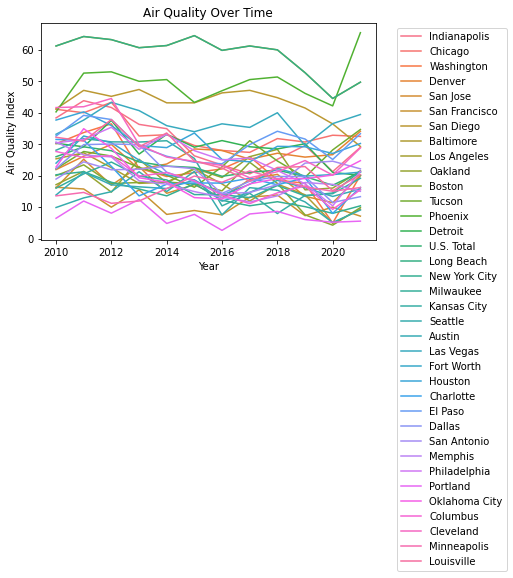

In [225]:
sns.lineplot(data=air_quality_data, x='date_label', y='value', hue='geo_label_city', ci=None)
plt.title('Air Quality Over Time')
plt.xlabel('Year')
plt.ylabel('Air Quality Index')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**To get a less busy time series plot, we split the data into groups based on their first Air Quality Value (2010).**

In [222]:
# Get the first period air quality data
first_period_data = air_quality_data[air_quality_data['date_label'] == air_quality_data['date_label'].min()]

# Define air quality groups
air_quality_groups = {'<30': [], '30-40': [], '40-60': [], '60+': []}

# Assign cities to their air quality groups
for city in first_period_data['geo_label_city'].unique():
    city_value = first_period_data[first_period_data['geo_label_city'] == city]['value'].values[0]
    if city_value < 25:
        air_quality_groups['<30'].append(city)
    elif city_value < 40:
        air_quality_groups['30-40'].append(city)
    elif city_value < 60:
        air_quality_groups['40-60'].append(city)
    else:
        air_quality_groups['60+'].append(city)

# Print the air quality groups and their cities
for group, cities in air_quality_groups.items():
    print(f"{group}: {', '.join(cities)}")

<30: Seattle, Portland
30-40: Minneapolis, Boston, San Jose, San Francisco, Oakland, San Antonio, Austin, Milwaukee, New York City
40-60: U.S. Total, Fort Worth, Memphis, Philadelphia, Oklahoma City, Columbus, Charlotte, Las Vegas, Kansas City, Detroit, Baltimore, Louisville, Washington, Denver, Tucson, Dallas
60+: Cleveland, Indianapolis, Chicago, San Diego, Los Angeles, Phoenix, El Paso, Long Beach, Houston


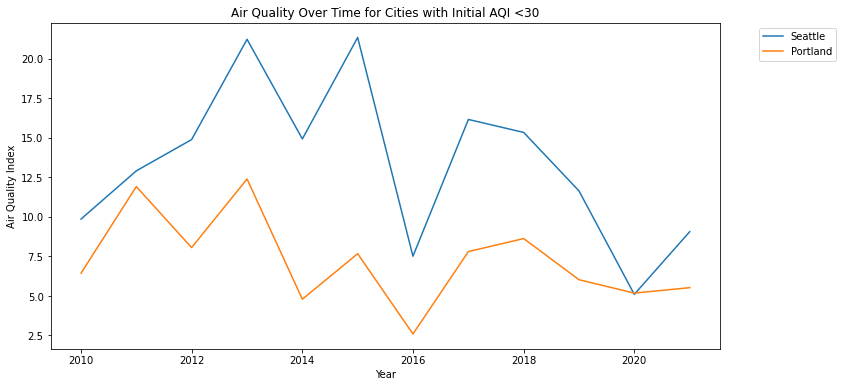

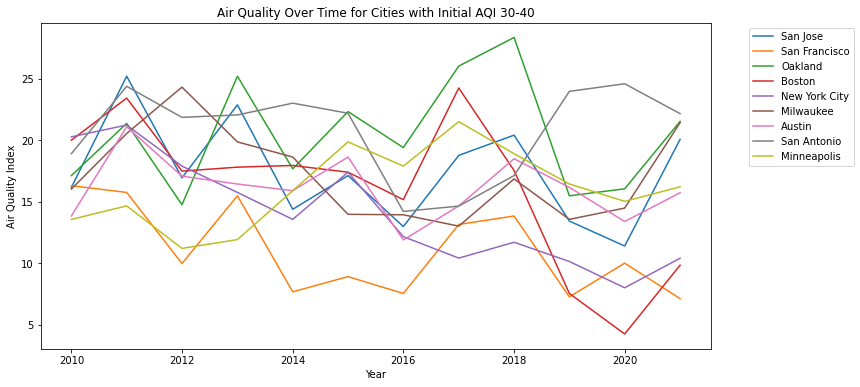

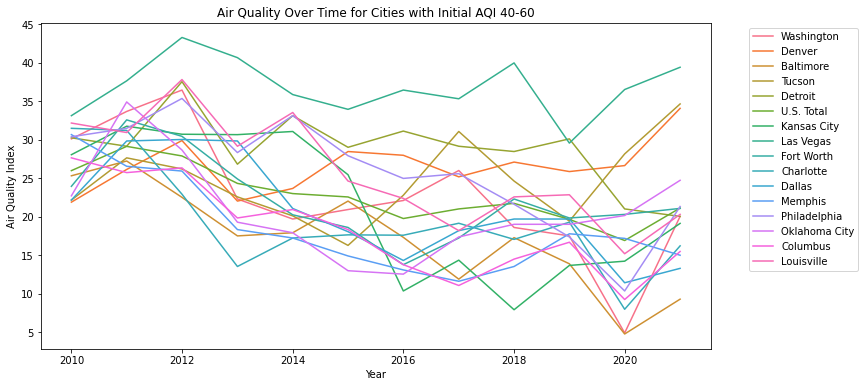

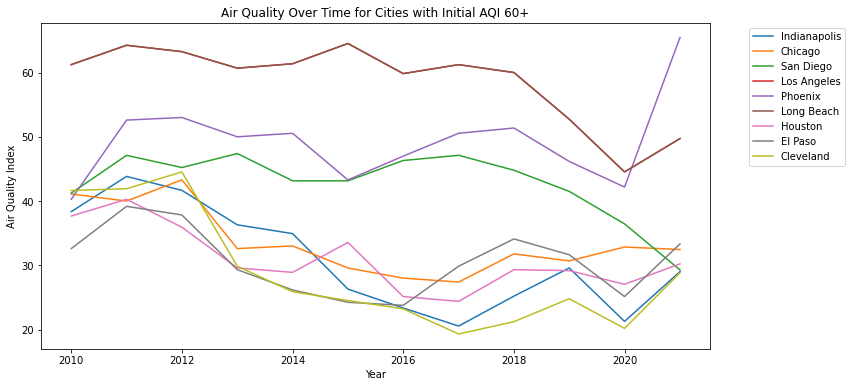

In [224]:
for group, cities in air_quality_groups.items():
    plt.figure(figsize=(12, 6))  # Set the figure size (width, height) in inches
    group_data = air_quality_data[air_quality_data['geo_label_city'].isin(cities)]
    sns.lineplot(data=group_data, x='date_label', y='value', hue='geo_label_city', ci=None)
    plt.title(f'Air Quality Over Time for Cities with Initial AQI {group}')
    plt.xlabel('Year')
    plt.ylabel('Air Quality Index')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

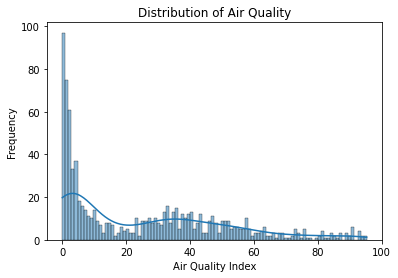

In [213]:
sns.histplot(data=air_quality_data, x='value', kde=True, bins=100)
plt.title('Distribution of Air Quality')
plt.xlabel('Air Quality Index')
plt.ylabel('Frequency')
plt.show()

In [ ]:
columns_to_keep = ['geo_label_citystate', 'value', 'date_label', 'metric_item_label', 'metric_subcat_label']
data = data[columns_to_keep]

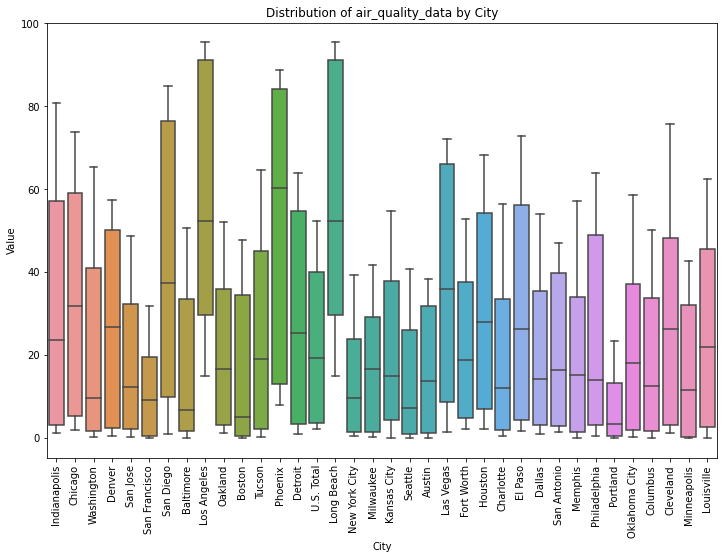

In [216]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='geo_label_city', y='value', data=air_quality_data)
plt.title('Distribution of air_quality_data by City')
plt.xlabel('City')
plt.ylabel('Value')
plt.xticks(rotation=90)
plt.show()

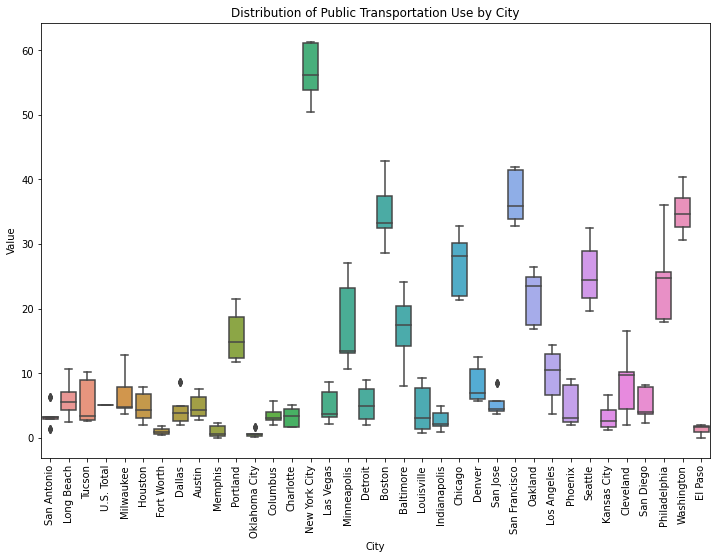

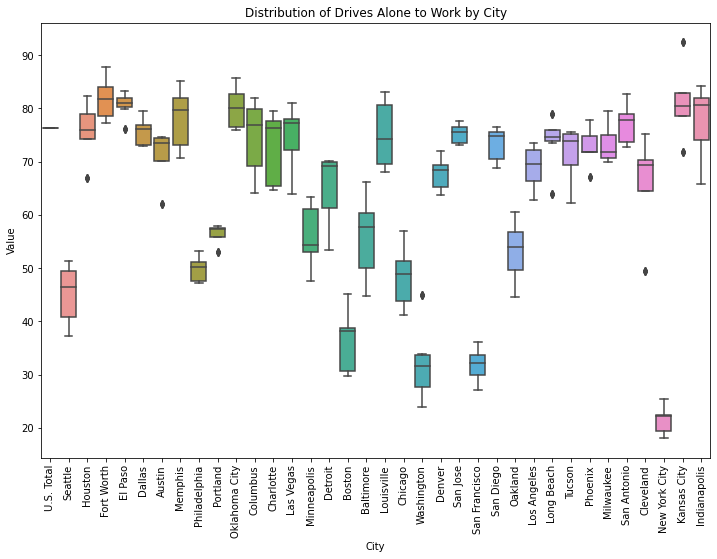

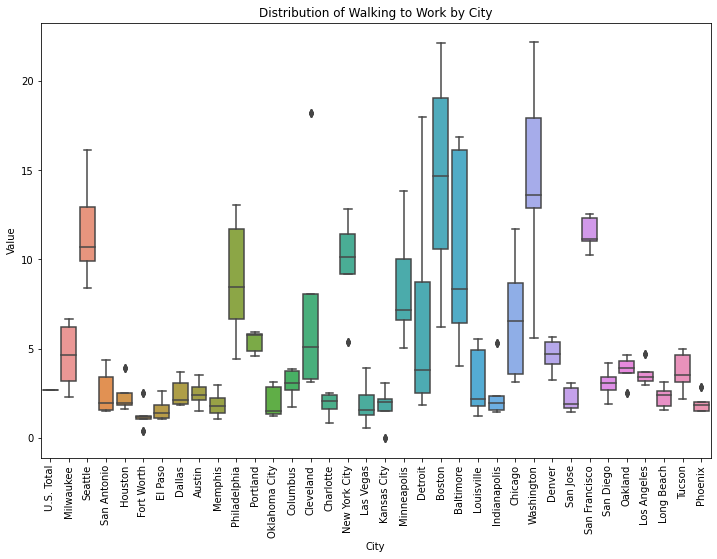

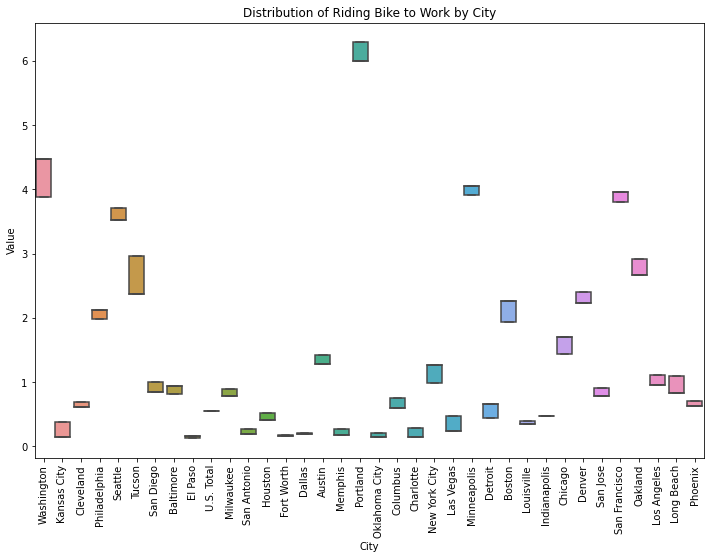

In [208]:
# Create a boxplot for each variable of interest, grouped by city
for variable in variables_of_interest:
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='geo_label_city', y='value', data=filtered_data[filtered_data['metric_item_label'] == variable])
    plt.title(f'Distribution of {variable} by City')
    plt.xlabel('City')
    plt.ylabel('Value')
    plt.xticks(rotation=90)
    plt.show()

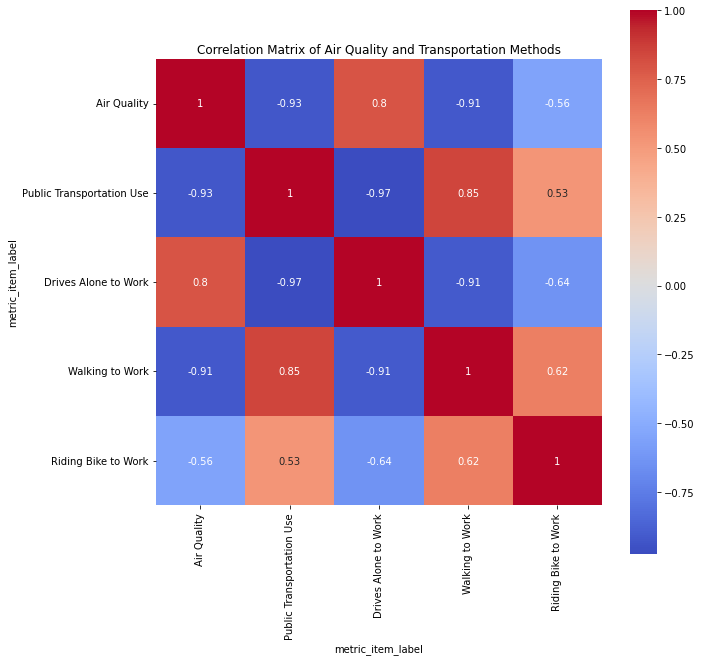

In [209]:
# Reshape the filtered dataset to have one row per city and year, with columns for each variable of interest
pivot_data = filtered_data.pivot_table(index=['geo_label_city', 'date_label'], columns='metric_item_label', values='value', aggfunc=np.mean).reset_index()

# Add the 'Air Quality' column to the pivot table
pivot_data['Air Quality'] = air_quality_data['value']

# Calculate the correlation matrix for the variables of interest, including 'Air Quality'
variables_of_interest = ['Air Quality', 'Public Transportation Use', 'Drives Alone to Work', 'Walking to Work', 'Riding Bike to Work']
correlation_matrix = pivot_data[variables_of_interest].corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Air Quality and Transportation Methods')
plt.show()

**There seems to be** some interesting correlations. 

But before we lock in on our proposedly important independent features: **[Public Transportation Use, Drives Alone to Work, Walking to Work, Riding Bike to Work]**, we must try to identify other features that have relationships to our target feature **"Air Quality"**.

In [210]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

In [211]:
pivot_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   geo_label_city             432 non-null    object        
 1   date_label                 432 non-null    datetime64[ns]
 2   Drives Alone to Work       432 non-null    float64       
 3   Hazardous Air Quality      432 non-null    float64       
 4   Poor Air Quality           432 non-null    float64       
 5   Public Transportation Use  432 non-null    float64       
 6   Riding Bike to Work        432 non-null    float64       
 7   Walking to Work            432 non-null    float64       
 8   Air Quality                3 non-null      float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 30.5+ KB


**What if we split the data into one dataset per. city?**

### Analysis

>**Regression**: **Predict poor air quality based on transportation methods**